## 📚 1. Load and Preprocess Module

In [14]:
# ------------------------
# 📦 Libraries Loading
# ------------------------

from statsbombpy import sb
import pandas as pd
from pandas.plotting import table
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.table import Table
from mplsoccer import Pitch
from scipy.stats import gaussian_kde
import matplotlib.font_manager as fm
from matplotlib.pyplot import subplots
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties

In [15]:
# Set the font properties
plt.rcParams['font.family'] = 'Courier New'

bold_font = FontProperties(weight='bold')

In [3]:
# ------------------------
# 📦 Data Loading
# ------------------------

# Fetch metadata for all Bundesliga 2023/24 matches
# Bayer Leverkusen matches will be filtered later
lev_matches = sb.matches(competition_id=9, season_id=281)

# Extract unique match IDs for Bayer Leverkusen
match_ids = lev_matches['match_id'].unique()

# Container for event-level data from each match
all_events = []

# Loop through each match ID to collect detailed event data
for match_id in match_ids:
    try:
        # Retrieve event-level data from StatsBomb for the given match
        df = sb.events(match_id=match_id)

        # Attach match-level metadata: match ID and match date
        match_date = lev_matches[lev_matches['match_id'] == match_id]['match_date'].values[0]
        df['match_id'] = match_id
        df['match_date'] = pd.to_datetime(match_date)

        # Append to list
        all_events.append(df)
    except Exception as e:
        # Print an error message if data retrieval fails
        print(f"Failed to fetch data for match {match_id}: {e}")

# Combine all individual match DataFrames into a single DataFrame
events = pd.concat(all_events, ignore_index=True)


In [6]:
# ------------------------
# 📦 Data Preprocessing
# ------------------------

def preprocess_events(events_df):
    """
    Preprocess the StatsBomb event DataFrame.

    - Expands the 'location' column into separate 'x' and 'y' coordinates.
    - Handles symmetry by flipping coordinates for second-half events,
      aligning all actions to one attacking direction (left to right).
    """
    df = events_df.copy()

    # Extract x and y coordinates from the 'location' list
    df[['x', 'y']] = df['location'].apply(
        lambda loc: pd.Series(loc) if isinstance(loc, list) else pd.Series([None, None])
    )

    # Fill missing period data with default value (1st half)
    df['period'] = df['period'].fillna(1)

    # Flip pitch coordinates for second half to normalize direction of play
    df['x'] = df.apply(lambda row: 120 - row['x'] if row['period'] == 2 else row['x'], axis=1)
    df['y'] = df.apply(lambda row: 80 - row['y'] if row['period'] == 2 else row['y'], axis=1)

    return df

# Preprocess the events DataFrame
events_df = preprocess_events(events)


In [7]:
# 🔄 Normalize Player Names for Consistency

# Some players have long or inconsistent full names in the dataset, which can clutter visualizations or tables.
# This dictionary maps full player names to shorter, more readable versions (e.g., "Florian Wirtz" → "F. Wirtz").
# It ensures uniformity in player naming across the analysis.

name_map = {
    'Amine Adli': 'A. Adli',
    'Edmond Fayçal Tapsoba': 'E. Tapsoba',
    'Jonathan Tah': 'J. Tah',
    'Robert Andrich': 'R. Andrich',
    'Granit Xhaka': 'G. Xhaka',
    'Jonas Hofmann': 'J. Hofmann',
    'Piero Martín Hincapié Reyna': 'P. Hincapie',
    'Nathan Tella': 'N. Tella',
    'Odilon Kossonou': 'O. Kossonou',
    'Victor Okoh Boniface': 'V. Boniface',
    'Florian Wirtz': 'F. Wirtz',
    'Patrik Schick': 'P. Schick',
    'Jeremie Frimpong': 'J. Frimpong',
    'Exequiel Alejandro Palacios': 'E. Palacios',
    'Alejandro Grimaldo García': 'A. Grimaldo',
    'Borja Iglesias Quintas': 'B. Iglesias',
    'Adam Hložek': 'A. Hložek',
    'Arthur Augusto de Matos Soares': 'Arthur',
    'Gustavo Adolfo Puerta Molano': 'G. Puerta',
    'Josip Stanišić': 'J. Stanisic',
    'Nadiem Amiri': 'N. Amiri',
    'Noah Mbamba': 'N. Mbemba',
    'Lukáš Hrádecký': 'L. Hrádecký'
}

events_df['player'] = events_df['player'].replace(name_map)


## 2. DEFENSE ANALYSIS

In [8]:
# 🛡️ Filter Defensive Actions for a Specific Team

def filter_defensive_actions(events_df, team_name='Bayer Leverkusen'):
    """
    Filter and return key defensive actions performed by a specific team.

    Included actions:
        - Duel (only if won)
        - Interception
        - Block
        - Clearance
        - Pressure

    Parameters:
        events_df (DataFrame): Full StatsBomb events DataFrame.
        team_name (str): Team to filter actions for. Default is 'Bayer Leverkusen'.

    Returns:
        DataFrame: Filtered DataFrame containing only selected defensive actions
                   performed by the specified team.
    """

    # Define defensive action types of interest
    valid_types = ['Duel', 'Interception', 'Block', 'Clearance', 'Pressure']

    # Filter rows where action is defensive and belongs to the specified team
    df = events_df[
        events_df['type'].isin(valid_types) & (events_df['team'] == team_name)
    ].copy()

    # Keep only successful duels (exclude 'Lost' and 'Neutral')
    duel_mask = (df['type'] != 'Duel') | (df['duel_outcome'] == 'Won')
    df = df[duel_mask]

    return df

# Filter events for Bayer Leverkusen's defensive actions
events_def = filter_defensive_actions(events_df, team_name='Bayer Leverkusen')

## 2.1. Player-Specific Scatter Plot Function

In [36]:
# 📍 Visualize Defensive Actions by Player and Action Type

def plot_player_recoveries(events_def, players=None, match_id=None, action_types=None, title='Defensive Actions by Player'):
    """
    Visualizes defensive actions on the pitch with player-based coloring and action-type-based shapes.

    Key Features:
    - Color-coded markers by player
    - Shape-coded markers by action type
    - Optional filters: match_id, player(s), and action type(s)
    - Dual legends: Player (color) and Action Type (marker shape)

    Parameters:
        events_def (DataFrame): Filtered defensive actions DataFrame.
        players (list, optional): List of player names to include.
        match_id (int, optional): Match ID to filter by.
        action_types (list, optional): Types of defensive actions to include.
        title (str): Plot title.

    Returns:
        Displays a StatsBomb pitch plot with overlaid defensive actions.
    """

    # Set default action types if not specified
    if action_types is None:
        action_types = ['Duel', 'Interception', 'Pressure', 'Block', 'Clearance']

    filtered = events_def.copy()

    # Apply match filter if provided
    if match_id:
        filtered = filtered[filtered['match_id'] == match_id]

    # Filter for specified action types
    filtered = filtered[filtered['type'].isin(action_types)]

    # Filter for specified players, if any
    if players:
        filtered = filtered[filtered['player'].isin(players)]

    # Assign a distinct color to each player
    custom_colors = ['red', 'blue', 'green', 'black', 'purple', 'orange', 'deeppink', 'teal']
    unique_players = filtered['player'].unique()
    player_color_map = {player: color for player, color in zip(unique_players, custom_colors)}
    filtered['color'] = filtered['player'].map(player_color_map)

    # Assign unique marker shapes to each action type
    marker_shapes = {
        'Duel': 'o',          # Circle
        'Interception': 's',  # Square
        'Pressure': 'P',      # Plus (filled)
        'Block': 'D',         # Diamond
        'Clearance': 'X'      # X-shaped
    }

    # Draw StatsBomb pitch using mplsoccer
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
    fig, ax = pitch.draw(figsize=(14, 8))

    # Plot each action with the corresponding color and shape
    for _, row in filtered.iterrows():
        ax.scatter(
            row['x'], row['y'],
            color=row['color'],
            edgecolors='black',
            s=80,
            marker=marker_shapes.get(row['type'], 'o')
        )

    # Create player legend (color-coded)
    player_handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=player_color_map[player], markersize=12)
        for player in unique_players
    ]
    player_labels = [
        f"{player} ({len(filtered[filtered['player'] == player])})"
        for player in unique_players
    ]
    legend1 = ax.legend(player_handles, player_labels,
                        loc='center left', bbox_to_anchor=(1, 0.6),
                        fontsize=8, title="Players (Events)", prop=bold_font, title_fontproperties=bold_font)
    ax.add_artist(legend1)

    # Create action type legend (shape-coded)
    unique_actions = filtered['type'].unique()
    action_handles = [
        plt.Line2D([0], [0], marker=marker_shapes.get(action, 'o'),
                   color='black', linestyle='None', markersize=8)
        for action in unique_actions
    ]
    ax.legend(action_handles, unique_actions,
              loc='center left', bbox_to_anchor=(1, 0.4),
              fontsize=10, title="Action Types", prop=bold_font, title_fontproperties=bold_font)

    # Set overall plot title
    plt.title(title, fontsize=16, fontweight='bold', color='black')
    plt.show()


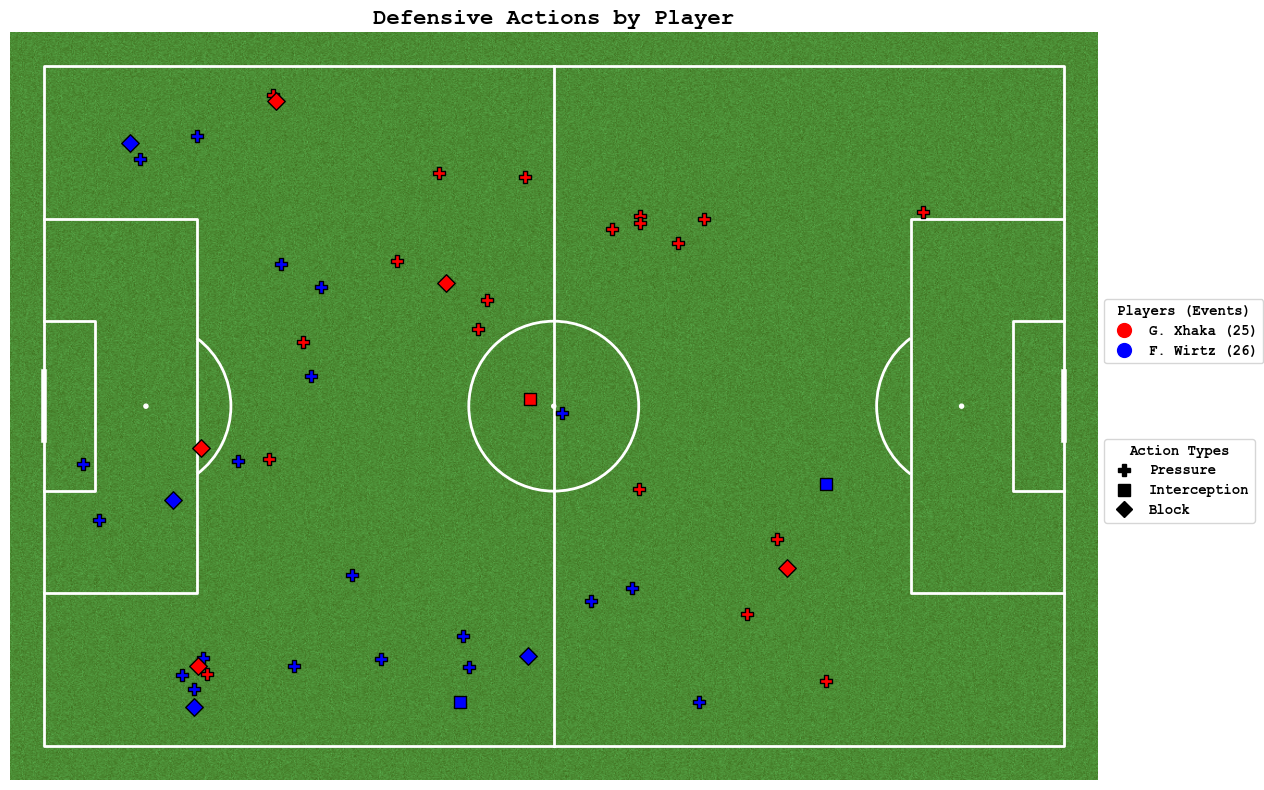

In [37]:
# Example usage of the function
plot_player_recoveries(events_def, players=['F. Wirtz', 'G. Xhaka'], match_id=3895302)

##  2.2. Defensive Actions Table - Pressure Table

In [21]:
# 📊 Generate Top Defensive Players Table (Duel, Interception, Block, Clearance)

def generate_defensive_table(events_def, match_ids=None, min_minutes_threshold=30, top_n=10):
    """
    Generates a ranked table of top defensive performers from Bayer Leverkusen.

    Included stats:
        - Duel (only won)
        - Interception
        - Block
        - Clearance
        - Total defensive actions
        - Estimated minutes played
        - Actions per 90 minutes (Per90)

    Parameters:
        events_def (DataFrame): Filtered defensive actions DataFrame.
        match_ids (list, optional): List of match IDs to filter by.
        min_minutes_threshold (int): Minimum minutes required to include player in final table.
        top_n (int): Number of top players to return.

    Returns:
        DataFrame: Summary table of top defensive players, sorted by total actions.
    """

    # Keep only relevant action types
    df = events_def.copy()
    df = df[df['type'].isin(['Duel', 'Interception', 'Block', 'Clearance'])]

    # Optionally filter for specific matches
    if match_ids:
        df = df[df['match_id'].isin(match_ids)]

    # Keep only Bayer Leverkusen actions and only 'Won' duels
    df = df[df['team'] == 'Bayer Leverkusen']
    df = df[(df['type'] != 'Duel') | (df['duel_outcome'] == 'Won')]

    # Count each defensive action type per player
    action_counts = df.groupby(['player', 'type']).size().unstack(fill_value=0)

    # Total defensive actions per player
    total_actions = df['player'].value_counts().rename('Total Actions')

    # Estimate minutes played by summing the highest minute per match per player
    minutes_df = df.groupby(['match_id', 'player'])['minute'].max().reset_index()
    minutes = minutes_df.groupby('player')['minute'].sum().rename('Minutes')

    # Combine all metrics into a single table
    stats = pd.concat([total_actions, minutes, action_counts], axis=1).dropna()

    # Calculate per 90 minutes rate
    stats['Per90'] = (stats['Total Actions'] / stats['Minutes']) * 90

    # Filter by minimum minutes played
    stats = stats[stats['Minutes'] >= min_minutes_threshold]

    # Sort by total actions and return top N players
    stats = stats.sort_values('Total Actions', ascending=False).head(top_n).reset_index()

    return stats.rename(columns={'player': 'Player'})

# Generate the defensive table for Bayer Leverkusen
top_defenders = generate_defensive_table(events_def)


In [23]:
# 📋 Display Styled Table of Top Defensive Players (Matplotlib)

def defensive_table(events_def, title="Top Leverkusen Players by Defensive Actions"):
    """
    Displays a visually enhanced ranking table of top defensive players using matplotlib.

    - Automatically adds rank column.
    - Zebra-style row shading for readability.
    - Custom font sizes and bold styling.
    - Responsive height based on number of rows.

    Parameters:
        events_def (DataFrame): DataFrame output from generate_defensive_table().
        title (str): Title of the table visualization.

    Returns:
        Renders a styled matplotlib table.
    """

    # Round Per90 values for cleaner appearance
    if 'Per90' in events_def.columns:
        events_def['Per90'] = events_def['Per90'].round(2)

    display_df = events_def.copy()

    # Add ranking column to the beginning
    display_df.insert(0, "#", range(1, len(display_df) + 1))

    # Prepare headers and data for the table
    col_labels = display_df.columns.tolist()
    cell_data = display_df.to_numpy().tolist()

    # Adjust figure height dynamically based on number of players
    fig_height = 0.7 + 0.5 * len(cell_data)
    fig, ax = plt.subplots(figsize=(15, fig_height))
    ax.set_axis_off()  # Hide axes for a clean table layout

    # Add main title above the table
    fig.text(0.5, 0.96, title, ha='center', va='center', fontsize=22, weight='bold')

    # Create a matplotlib table
    table = Table(ax, bbox=[0, 0, 1, 0.9])

    # Define column widths (adjust if number of columns changes)
    col_widths = [0.4, 1, 1, 1, 1, 1, 1, 1, 1]

    # Header row with red background and white bold text
    for col_idx, label in enumerate(col_labels):
        cell = table.add_cell(0, col_idx, width=col_widths[col_idx], height=0.2,
                              text=label, loc='center', facecolor='red')
        cell.get_text().set_color('white')
        cell.get_text().set_fontsize(28)
        cell.get_text().set_weight('bold')

    # Add data rows with alternating background colors (zebra styling)
    for row_idx, row in enumerate(cell_data):
        for col_idx, val in enumerate(row):
            bgcolor = '#f9f9f9' if row_idx % 2 == 0 else '#e5e5e5'
            cell = table.add_cell(row_idx + 1, col_idx, width=col_widths[col_idx], height=0.2,
                                  text=str(val), loc='center', facecolor=bgcolor)
            cell.get_text().set_fontsize(30)
            cell.get_text().set_weight('bold')

    # Add table to the axes
    ax.add_table(table)

    # Optimize layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


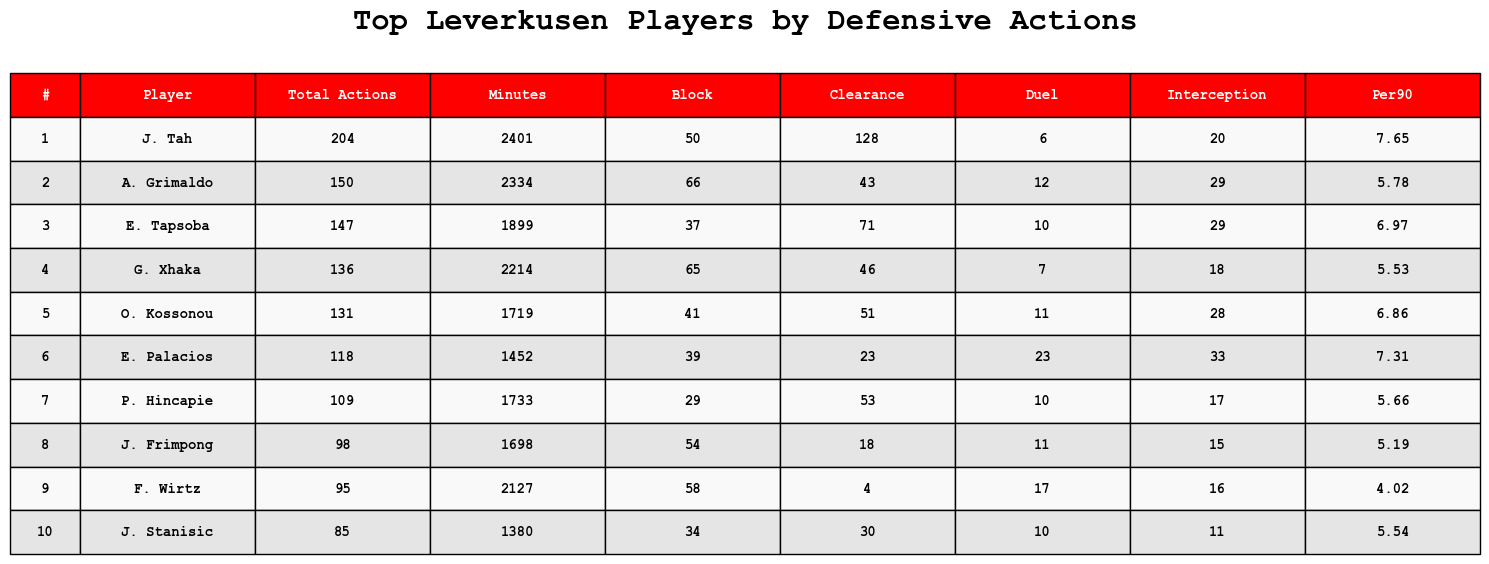

In [24]:
defensive_table(top_defenders)

In [25]:
# 🧠 Generate Top Pressure Actions Table

def generate_pressure_table(events_def, match_ids=None, min_minutes_threshold=30, top_n=10):
    """
    Generates a ranking table of Bayer Leverkusen players based on their pressure actions.

    Metrics included:
        - Total pressure actions
        - Estimated minutes played
        - Pressure actions per 90 minutes

    Parameters:
        events_def (DataFrame): Defensive actions DataFrame including pressure events.
        match_ids (list, optional): List of specific match IDs to filter by.
        min_minutes_threshold (int): Minimum minutes played to be included in results.
        top_n (int): Number of top players to return.

    Returns:
        DataFrame: A ranked table of players with the most pressure actions.
    """

    df = events_def.copy()

    # Keep only pressure events from Bayer Leverkusen
    df = df[(df['type'] == 'Pressure') & (df['team'] == 'Bayer Leverkusen')]

    # Filter by match IDs if provided
    if match_ids:
        df = df[df['match_id'].isin(match_ids)]

    # Count total pressure actions per player
    pressure_count = df['player'].value_counts().rename('Pressure Actions')

    # Estimate minutes played by each player (based on max minute per match)
    minutes_df = df.groupby(['match_id', 'player'])['minute'].max().reset_index()
    minutes = minutes_df.groupby('player')['minute'].sum().rename('Minutes')

    # Combine pressure counts and minutes into a single table
    stats = pd.concat([pressure_count, minutes], axis=1).dropna()

    # Calculate pressure actions per 90 minutes
    stats['Pressure per90'] = (stats['Pressure Actions'] / stats['Minutes']) * 90

    # Apply minimum minutes threshold
    stats = stats[stats['Minutes'] >= min_minutes_threshold]

    # Sort by total pressure actions and return top N players
    stats = stats.sort_values('Pressure Actions', ascending=False).head(top_n).reset_index()

    return stats.rename(columns={'player': 'Player'})

# Generate the pressure table for Bayer Leverkusen
pressure_df = generate_pressure_table(events_def)

In [26]:
# 📋 Display Styled Table of Top Pressure Events

def pressure_table(events_def, title="Top Leverkusen Players by Pressure Events"):
    """
    Displays a styled Matplotlib table of Leverkusen players ranked by pressure actions.

    Columns:
        - Player
        - Total Pressure Actions
        - Minutes Played
        - Pressure per 90 Minutes

    Highlights:
        - Zebra row style
        - Compact format
        - Responsive figure height
    """

    # Prepare and round key columns
    display_df = events_def[['Player', 'Pressure Actions', 'Minutes', 'Pressure per90']].round(2).copy()
    display_df.insert(0, "#", range(1, len(display_df) + 1))  # Add rank column

    # Extract table data
    col_labels = display_df.columns.tolist()
    cell_data = display_df.to_numpy().tolist()

    # Auto-adjust figure height
    fig_height = 0.7 + 0.5 * len(cell_data)
    fig, ax = plt.subplots(figsize=(15, fig_height))
    ax.set_axis_off()

    # Add title
    fig.text(0.5, 0.96, title, ha='center', va='center', fontsize=22, weight='bold')

    # Build manual table
    table = Table(ax, bbox=[0, 0, 1, 0.9])
    col_widths = [0.07, 0.3, 0.3, 0.3, 0.3]

    # Add header row
    for col_idx, label in enumerate(col_labels):
        cell = table.add_cell(0, col_idx, width=col_widths[col_idx], height=0.2,
                              text=label, loc='center', facecolor='red')
        cell.get_text().set_color('white')
        cell.get_text().set_fontsize(14)
        cell.get_text().set_weight('bold')

    # Add data rows with zebra styling
    for row_idx, row in enumerate(cell_data):
        for col_idx, val in enumerate(row):
            bgcolor = '#f9f9f9' if row_idx % 2 == 0 else '#e5e5e5'
            cell = table.add_cell(row_idx + 1, col_idx, width=col_widths[col_idx], height=0.2,
                                  text=str(val), loc='center', facecolor=bgcolor)
            cell.get_text().set_fontsize(14)
            cell.get_text().set_weight('bold')

    ax.add_table(table)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


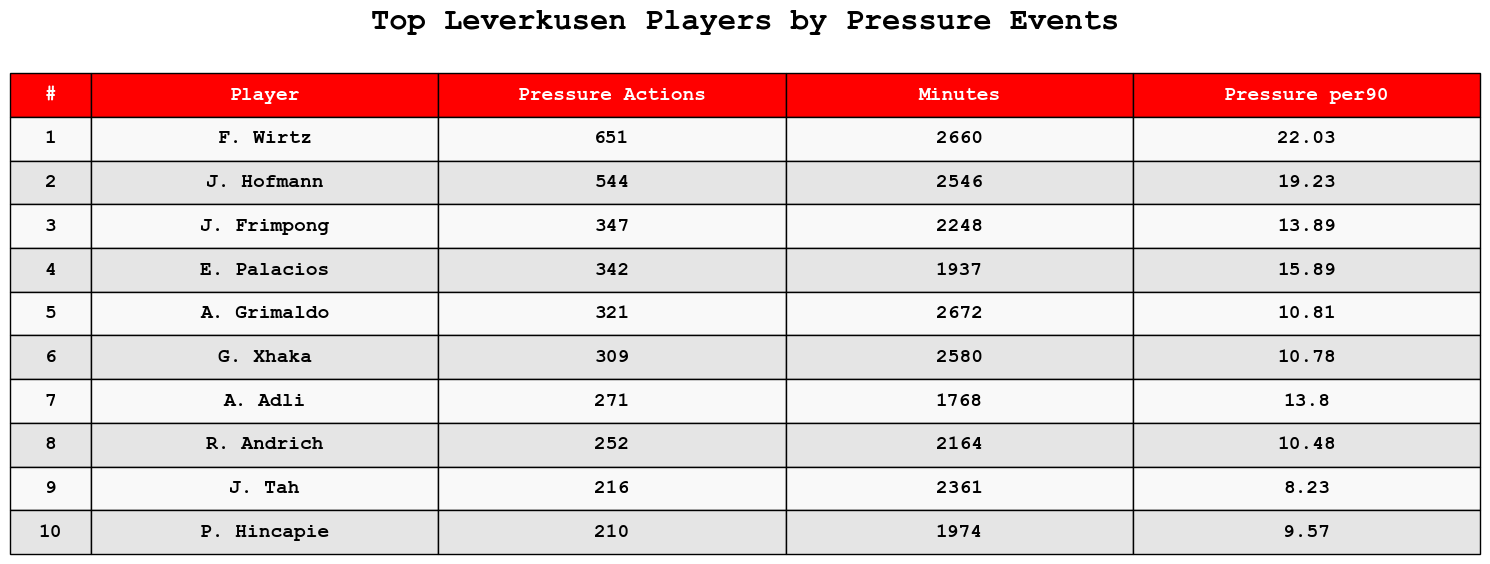

In [27]:
pressure_table(pressure_df)

## 3. OFFENSE ANALYSIS

In [29]:
# Filter Offensive Actions for a Specific Team

def filter_offensive_actions(events_df, team_name='Bayer Leverkusen'):
    """
    Generates an offensive summary table for the specified team.

    Metrics:
        - Shots
        - Total xG
        - Goals
        - Key Passes
        - Goals - xG (finishing efficiency)

    Parameters:
        events_df (DataFrame): Full StatsBomb events dataframe.
        team_name (str): Team name to filter actions for.

    Returns:
        DataFrame: Offensive summary per player, sorted by Total xG.
    """
    # Filter events for the given team
    offensive_df = events_df[events_df['team'] == team_name]

    # Shots with valid xG values
    shots = offensive_df[
        (offensive_df['type'] == 'Shot') & 
        (offensive_df['shot_statsbomb_xg'].notnull())
    ]
    xg_per_player = shots.groupby('player')['shot_statsbomb_xg'].sum().reset_index()
    xg_per_player.columns = ['Player', 'Total xG']

    # Shot count per player
    shot_counts = shots.groupby('player').size().reset_index(name='Shots')
    shot_counts.columns = ['Player', 'Shots']

    # Key passes (passes that assisted a shot)
    passes = offensive_df[
        (offensive_df['type'] == 'Pass') & 
        (offensive_df['pass_assisted_shot_id'].notnull())
    ]
    xa_per_player = passes.groupby('player').size().reset_index(name='Key Passes')
    xa_per_player.columns = ['Player', 'Key Passes']

    # Goal count per player
    goals = offensive_df[
        (offensive_df['type'] == 'Shot') & 
        (offensive_df['shot_outcome'] == 'Goal')
    ]
    goal_counts = goals.groupby('player').size().reset_index(name='Goals')
    goal_counts.columns = ['Player', 'Goals']

    # Merge all metrics into one table
    offense_summary = pd.merge(shot_counts, xg_per_player, on='Player', how='outer')
    offense_summary = pd.merge(offense_summary, xa_per_player, on='Player', how='outer')
    offense_summary = pd.merge(offense_summary, goal_counts, on='Player', how='outer')

    # Final formatting and calculations
    offense_summary['Total xG'] = offense_summary['Total xG'].round(2)
    offense_summary['Key Passes'] = offense_summary['Key Passes'].fillna(0).astype(int)
    offense_summary['Goals'] = offense_summary['Goals'].fillna(0).astype(int)
    offense_summary['Goals - xG'] = (offense_summary['Goals'] - offense_summary['Total xG']).round(2)
    offense_summary = offense_summary.fillna(0)
    offense_summary = offense_summary.sort_values(by='Total xG', ascending=False).reset_index(drop=True)

    return offense_summary

# Generate the offensive summary table for Bayer Leverkusen
offensive_summary = filter_offensive_actions(events_df, team_name='Bayer Leverkusen')

## 3.1. Offensive Actions Table

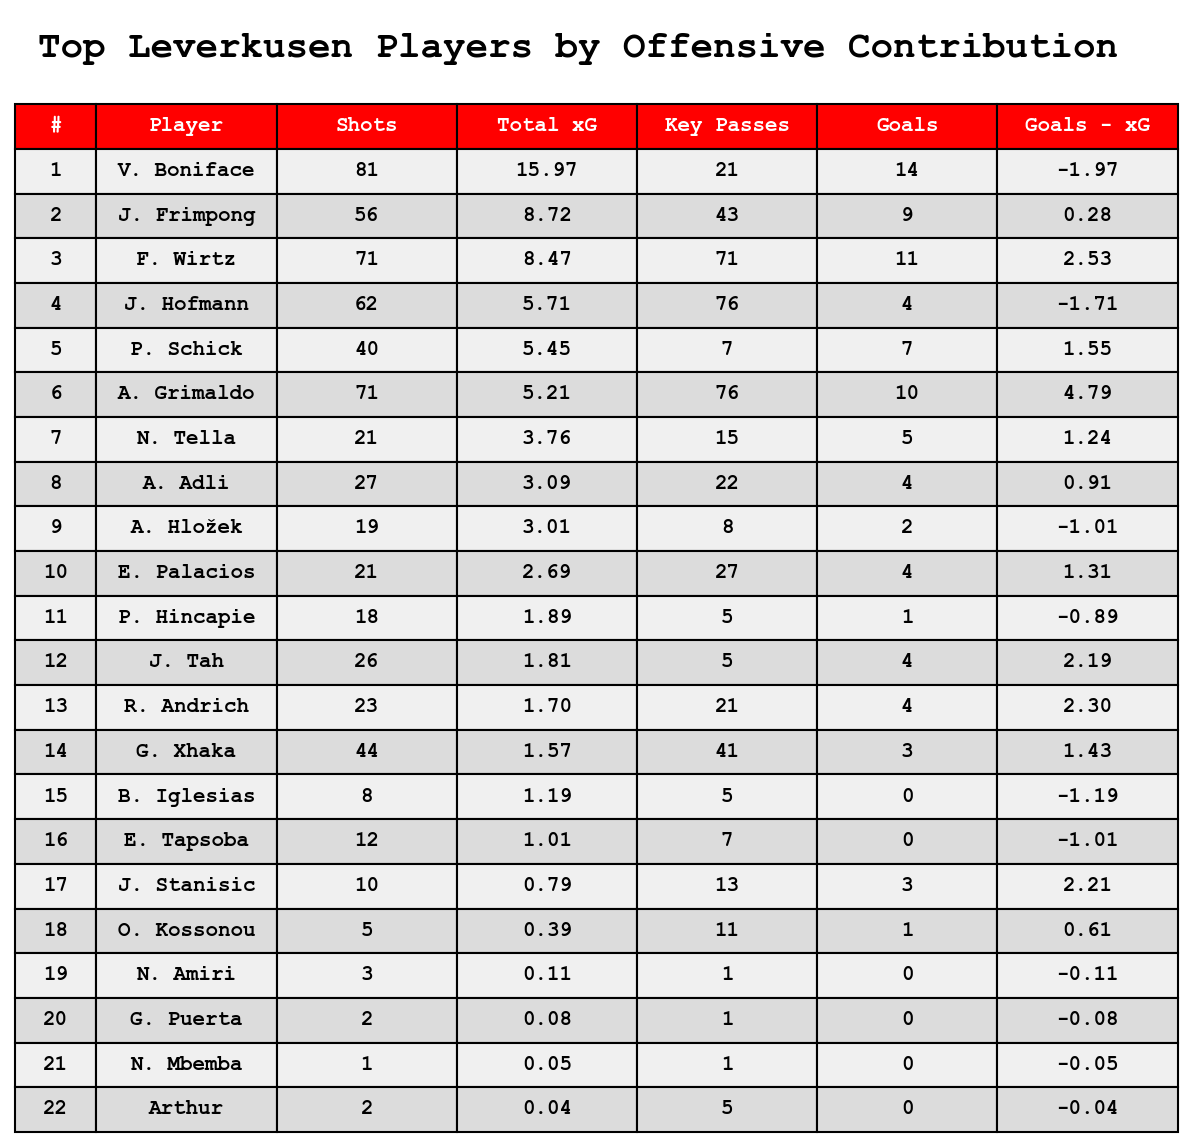

In [ ]:
# 📊 Generate Offensive Summary Table

def offense_table(offensive_df, title="Top Leverkusen Players by Offensive Contribution"):
    """
    Creates a styled, index-free matplotlib table for offensive metrics.
    """
    display_df = offensive_df.copy()
    display_df.insert(0, "#", range(1, len(display_df) + 1))

    col_labels = display_df.columns.tolist()
    cell_data = display_df.to_numpy().tolist()

    fig_height = 1 + 0.3 * len(cell_data)
    fig, ax = subplots(figsize=(10, fig_height), dpi=150)
    ax.set_axis_off()

    fig.text(0.5, 0.96, title, ha='center', va='center', fontsize=18, weight='bold')

    table = Table(ax, bbox=[0, 0, 1, 0.92])
    col_count = len(col_labels)
    col_widths = [0.07] + [0.93 / (col_count - 1)] * (col_count - 1)

    for col_idx, label in enumerate(col_labels):
        cell = table.add_cell(0, col_idx, width=col_widths[col_idx], height=0.22,
                              text=label, loc='center', facecolor='red')
        cell.get_text().set_color('white')
        cell.get_text().set_fontsize(10)
        cell.get_text().set_weight('bold')

    for row_idx, row in enumerate(cell_data):
        for col_idx, val in enumerate(row):
            text_val = f"{val:.2f}" if isinstance(val, float) else str(val)
            bgcolor = '#f0f0f0' if row_idx % 2 == 0 else '#dcdcdc'
            cell = table.add_cell(row_idx + 1, col_idx, width=col_widths[col_idx], height=0.22,
                                  text=text_val, loc='center', facecolor=bgcolor)
            cell.get_text().set_fontsize(10)
            cell.get_text().set_weight('bold')

    ax.add_table(table)
    fig.subplots_adjust(top=0.99, bottom=0.01)
    fig.show()

# Display the table
offense_table(offensive_summary)


## 3.2. Shot Map with xG & Goal Highlighting

In [34]:
# 📊 Shot Map for Selected Players

def plot_player_shot_map(events_df, players=None, xg_threshold=0.0, direction='above', team_name='Bayer Leverkusen'):
    """
    Visualizes shot locations for selected players in a match/event dataset.

    Features:
        - xG threshold filtering (above/below)
        - Half-symmetry: left = 1st half, right = 2nd half
        - Marker shape based on shot outcome
        - Marker color based on player identity
        - Marker edge color based on shot type (e.g. penalty, free kick)
        - Supports multiple players with combined legend

    Parameters:
        events_df (DataFrame): Full StatsBomb events DataFrame.
        players (list): Optional list of players to include.
        xg_threshold (float): Minimum (or maximum) xG value for filtering.
        direction (str): 'above' or 'below' xG threshold.
        team_name (str): Filter by team name (default = Bayer Leverkusen).
    """
    # 🧼 Filter valid shots for the given team
    shots_df = events_df[
        (events_df['team'] == team_name) &
        (events_df['type'] == 'Shot') &
        (events_df['shot_statsbomb_xg'].notnull()) &
        (events_df['location'].notnull())
    ].copy()

    # 🔁 Convert stringified locations to lists if necessary
    if isinstance(shots_df['location'].iloc[0], str):
        import ast
        shots_df['location'] = shots_df['location'].apply(ast.literal_eval)

    # 🗺️ Expand location into separate x/y coordinates
    shots_df[['x', 'y']] = shots_df['location'].apply(lambda loc: pd.Series(loc))

    # 👥 Filter by selected players if provided
    if players:
        shots_df = shots_df[shots_df['player'].isin(players)]

    # 🎚️ Filter by xG threshold and direction
    if direction == 'above':
        shots_df = shots_df[shots_df['shot_statsbomb_xg'] >= xg_threshold]
    elif direction == 'below':
        shots_df = shots_df[shots_df['shot_statsbomb_xg'] <= xg_threshold]

    # 🎯 Define marker shapes based on shot outcome
    outcome_markers = {
        'Goal': 'o', 'Saved': 's', 'Post': '^', 'Off T': 'X', 'Blocked': 'P',
        'Wayward': 'X', 'Offside': 'X', 'Saved To Post': 's', 'Saved Off T': 's'
    }
    shots_df['marker'] = shots_df['shot_outcome'].map(lambda o: outcome_markers.get(o, 'o'))

    # ↔️ Normalize pitch direction: 2nd half → right; 1st half → flip to left
    shots_df['x_plot'] = shots_df['x']
    shots_df.loc[shots_df['period'] == 1, 'x_plot'] = 120 - shots_df['x']
    shots_df['y_plot'] = shots_df['y']

    # ✨ Add small random jitter to penalty shots to prevent marker overlap
    if 'shot_type' in shots_df.columns:
        penalty_mask = shots_df['shot_type'] == 'Penalty'
        shots_df.loc[penalty_mask, 'x_plot'] += np.random.uniform(-0.7, 0.7, size=penalty_mask.sum())
        shots_df.loc[penalty_mask, 'y_plot'] += np.random.uniform(-0.7, 0.7, size=penalty_mask.sum())
    else:
        shots_df['shot_type'] = 'Open Play'

    # 🎨 Edge color based on shot type (penalty, free kick, open play)
    def get_edge_color(shot_type):
        if shot_type == 'Penalty':
            return 'gold'
        elif shot_type == 'Free Kick':
            return 'deepskyblue'
        else:
            return 'black'
    shots_df['edge_color'] = shots_df['shot_type'].map(get_edge_color)

    # 🎨 Color code by player using matplotlib color cycle
    unique_players = shots_df['player'].unique()
    color_map = {player: color for player, color in zip(unique_players, plt.cm.tab10.colors)}
    shots_df['color'] = shots_df['player'].map(color_map)

    # ⛔ Remove invalid or out-of-bounds coordinates
    shots_df = shots_df.dropna(subset=['x_plot', 'y_plot'])
    shots_df = shots_df[(shots_df['x_plot'] >= 0) & (shots_df['x_plot'] <= 120)]
    shots_df = shots_df[(shots_df['y_plot'] >= 0) & (shots_df['y_plot'] <= 80)]

    # 📐 Draw the pitch
    pitch = Pitch(pitch_color='grass', line_color='white')
    fig, ax = pitch.draw(figsize=(16, 8))

    # 🔘 Plot each shot with customized marker, color and edge
    for _, row in shots_df.iterrows():
        pitch.scatter(
            row['x_plot'], row['y_plot'],
            s=150,
            marker=row['marker'],
            color=row['color'],
            edgecolors=row['edge_color'],
            linewidth=1.5,
            alpha=0.85,
            ax=ax
        )

    # 🏷️ Set title
    plt.title("Leverkusen Shot Map — 1st Half (Left) vs 2nd Half (Right)",
              fontsize=18, weight='bold')

    # 📎 Create legends
    import matplotlib.lines as mlines

    # Player colors
    color_handles = [
        mlines.Line2D([], [], color=color_map[player], marker='o', linestyle='None', label=player)
        for player in unique_players
    ]

    # Outcome shapes
    used_shapes = shots_df[['marker', 'shot_outcome']].drop_duplicates()
    shape_handles = [
        mlines.Line2D([], [], color='gray', marker=row['marker'], linestyle='None',
                      label=row['shot_outcome'], markersize=10, markeredgecolor='black')
        for _, row in used_shapes.iterrows()
    ]

    # Shot type edge colors
    shot_types = shots_df['shot_type'].dropna().unique()
    type_handles = [
        mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                      markerfacecolor='none', markeredgecolor=get_edge_color(shot_type),
                      label=shot_type, markersize=10, linewidth=1.5)
        for shot_type in shot_types
    ]

    # Combine all legend elements
    ax.legend(
        handles=color_handles + shape_handles + type_handles,
        loc='center left', bbox_to_anchor=(1.01, 0.5),
        fontsize=10, title="Legend", prop=bold_font, title_fontproperties=bold_font
    )

    plt.show()


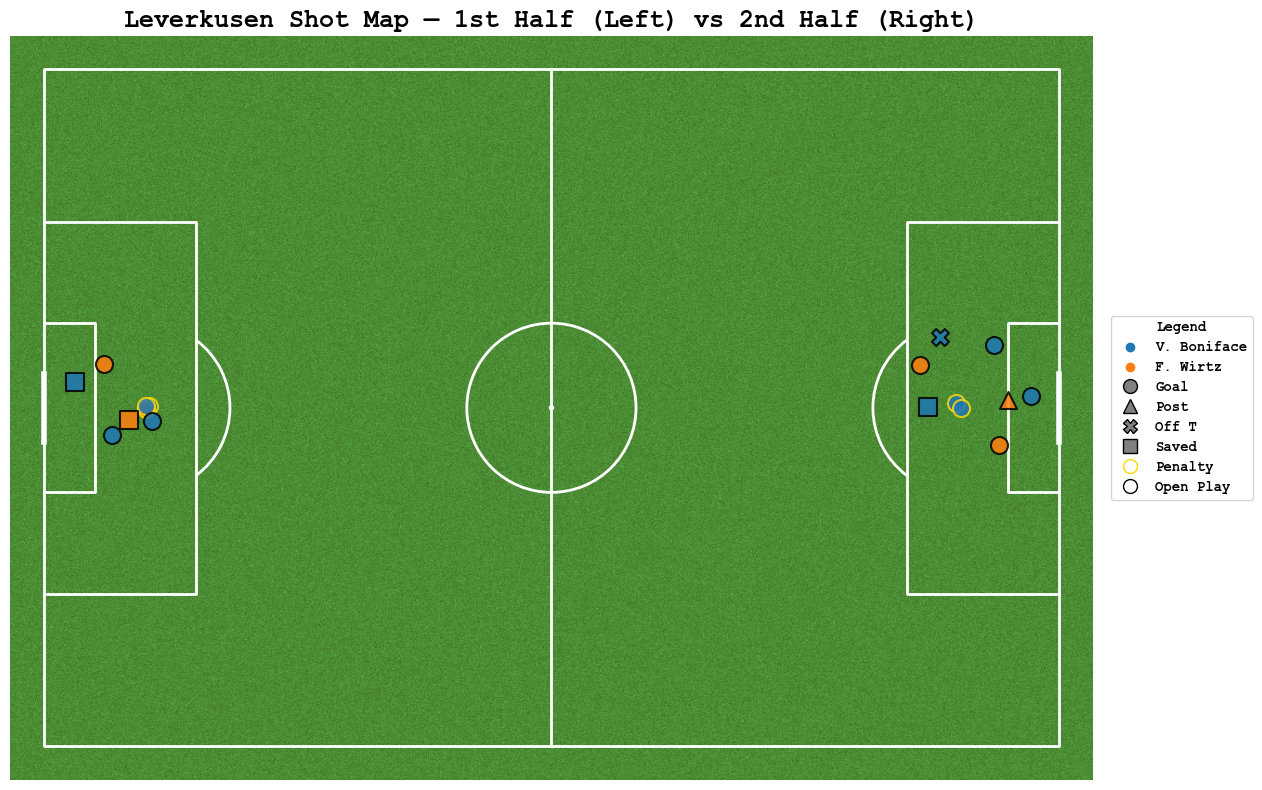

In [35]:
# 🔄 Run the shot map visualization for selected key attackers
# - Focus on high-quality chances (xG ≥ 0.4)
# - Compare Florian Wirtz vs Victor Boniface
plot_player_shot_map(
    events_df,
    players=['F. Wirtz', 'V. Boniface'],
    xg_threshold=0.4,
    direction='above'
)
